In [1]:
import os
import sys
sys.path.append('..')
os.chdir('..')

import cv2
import numpy as np
from skimage import morphology
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as nnf

# from model.AuxilaryNet import AuxNet
from model.UNet import UNet

from external.scarp import hiriseJPEG
from configs.config_parser import Config

In [2]:
conf = Config().getConfig()

[INFO] MODEL: UNet_default, DATASET: scarp, LOSS: segmentation


In [101]:
# BAD IDs: 4, 5, 16, 23, 25

imID = 19
imlist = [img for img in os.listdir(conf.FULL_RDR_PNG) if img.endswith('png')]
image = cv2.imread(f'{conf.FULL_RDR_PNG}/{imlist[imID]}', 0)
IMG = hiriseJPEG(image)
rot_mask = IMG.getMask(plot = False)
contour = IMG.getContour(rot_mask)
minbox  = IMG.getMinBox(contour, plot = False)
image = IMG.cropToMask(rot_mask, minbox, plot = False)
image = image.astype("float32") / 255


model = UNet(conf).to('cuda:0')

if CONF.NUM_GPU > 1:
    model.load_state_dict({key.replace(f'module.',''): value for key, value in torch.load(conf.MDL_PATH)['state_dict'].items()})
else:
    model.load_state_dict(torch.load(conf.MDL_PATH)['state_dict'])

In [102]:
og_height, og_width = image.shape[0], image.shape[1]
image = cv2.resize(image, (512*np.round(og_width/512).astype(int), 512*np.round(og_height/512).astype(int)))
mask = np.zeros_like(image)

In [103]:
model.eval()
with torch.no_grad():
    for h in range(0, image.shape[0]-256, 256):
        for w in range(0, image.shape[1]-256, 256):
            window = image[h:h+512, w:w+512]
            window = np.expand_dims(window, 0)
            window = np.expand_dims(window, 0)
            window = torch.from_numpy(window).to('cuda:0')
            
            predMask = model(window)
            predMask = predMask.squeeze(0).squeeze(0)
            predMask = torch.relu(torch.sign(torch.sigmoid(predMask)-0.5))
            predMask = predMask.cpu().numpy()
            predMask = predMask.astype(np.uint8)
            
#             # prepare a plot for visualization
#             prob = nnf.softmax(predLabel, dim=1)
#             prob = prob.cpu().detach().numpy().squeeze()
#             prob = np.round(prob, decimals=3)
#             predCls = np.argmax(prob)

#             if predCls == 0 and prob[predCls] > 0.8:
#                 predMask = np.zeros((512,512))
#             elif predCls == 1 and prob[predCls] > 0.8:
#                 predMask = np.ones((512,512))
#                 predMask = predMask.astype(np.uint8)
#             else:
#                 pass

            wmin, wmax = 128,384
            hmin, hmax = 128,384
            if w == 0:
                wmin = 0
            if w == (image.shape[1] - 512):
                wmax = 512
            if h == 0:
                hmin = 0
            if h == (image.shape[0] - 512):
                hmax = 512
            mask[h+hmin:h+hmax, w+wmin:w+wmax] = predMask[hmin:hmax, wmin:wmax]

mask = mask > 0
# mask = morphology.remove_small_holes(mask, area_threshold=500000)
# mask = morphology.remove_small_objects(mask, min_size=500000)

(-0.5, 2559.5, 2047.5, -0.5)

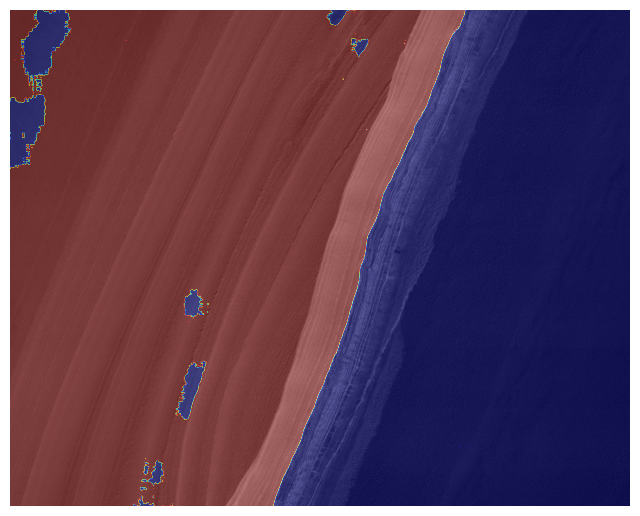

In [104]:
plt.figure(figsize=(8,8))
plt.imshow(image, cmap='gray')
plt.imshow(mask, cmap='jet', alpha=0.5)
plt.axis('off')

In [192]:
# masklist = [img for img in os.listdir(conf.MASK_DATASET_PATH) if img.endswith('png')]

# ice = 0
# for msk in masklist:
#     mask = cv2.imread(f'{conf.MASK_DATASET_PATH}/{msk}', 0)/255
#     ice += np.sum(mask)
# total_pixels = 512*512*len(masklist)
# bu = total_pixels - ice

# print(np.round(ice/total_pixels, 3))
# print(np.round(bu/ total_pixels, 3))

In [56]:
# unet.eval()
# with torch.no_grad():
#     for x in range(0, image.shape[0], 256):
#         for y in range(0, image.shape[1], 256):
#             if x + 512 > image.shape[0]:
#                 x = image.shape[0] - 512
#             if y + 512 > image.shape[1]:
#                 y = image.shape[1] - 512
#             tile = image[x:x+512, y:y+512]


#             tile = np.expand_dims(tile, 0)
#             tile = np.expand_dims(tile, 0)
#             tile = torch.from_numpy(tile).to(conf.DEVICE)

#             predLabel, predMask = unet(tile)
            
#             predMask = predMask.squeeze(0).squeeze(0)
#             predMask = torch.relu(torch.sign(torch.sigmoid(predMask)-0.5))
#             predMask = predMask.cpu().numpy()
#             predMask = predMask.astype(np.uint8)
#             # predMask = predMask[0]

#             # # prepare a plot for visualization
#             # prob = nnf.softmax(predLabel, dim=1)
#             # prob = prob.cpu().detach().numpy().squeeze(0)
#             # prob = np.round(prob, decimals=3)
#             # predCls = np.argmax(prob)

#             # if predCls == 0 and prob[predCls] > 0.8:
#             #     predMask = np.zeros((512,512))
#             #     # print(prob, 'BU')
#             # elif predCls == 1 and prob[predCls] > 0.8:
#             #     predMask = np.ones((512,512))
#             #     predMask = predMask.astype(np.uint8)
#             #     # print(prob, 'NPLD')
#             # else:
#             #     # print(prob, 'SCARP')
#             #     pass

#             mask[x:x+512, y:y+512] = mask[x:x+512, y:y+512]*predMask

# mask = mask > 0
# mask = morphology.remove_small_holes(mask, area_threshold=100000)
# mask = morphology.remove_small_objects(mask, min_size=100000)